In [2]:
from scipy.stats import entropy
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 12
from tqdm import tqdm
import sys
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/NEMO/src/')
from plot import *
import importlib

importlib.reload(sys.modules['plot'])
from plot import *

In [18]:
negctrlfile = '../data/uncalled_eventalign/220308_ang_0.sorted.eventalign.tsv'
posctrlfile = '../data/uncalled_eventalign/220308_ang_500.sorted.eventalign.tsv'
samples = ['ang_0', 'ang_500']
files =  [negctrlfile, posctrlfile]

In [43]:
####to get signal distribution from positive and negative control eventalign data

for i in range(2):
    print(samples[i])
    kmertosignal = {}
    file = files[i]
    for line in tqdm(open(file)):
        line = line.split('\t', 10)
        if line[0]=='contig':
            continue
        kmer = line[9]
        signalmean = float(line[6])
        if kmer not in kmertosignal: kmertosignal[kmer] = []
        kmertosignal[kmer].append(signalmean)
    kmerToHistDist = {}
    for kmer in kmertosignal:
        sigs = kmertosignal[kmer]
        hist, bin_edges = np.histogram(sigs, range(25, 150), density=True)
        kmerToHistDist[kmer] = list(hist)

    out = open('../data/uncalled_eventalign/220308_' + samples[i] + '_sig_dist_precalculated_hist.tsv', 'w')
    for kmer in kmerToHistDist:
        out.write(kmer + '\t' + ','.join([str(x) for x in kmerToHistDist[kmer]]) + '\n')
    out.close()

ang_0


714576611it [22:29, 529585.28it/s]


ang_500


205198519it [06:29, 526565.06it/s]


In [9]:
###to calculate and plot peaks for individual kmers from the signal distributions
kmerpeaks = {}
for line in open('../data/uncalled_eventalign/220308_ang_500_sig_dist_precalculated_hist.tsv'):
    line = line.rstrip().split('\t')
    hist = [float(x) for x in line[1].split(',')]
    if line[0] not in kmerpeaks: kmerpeaks[line[0]] = [hist]
    else: kmerpeaks[line[0]].append(hist)
for line in open('../data/uncalled_eventalign/220308_ang_0_sig_dist_precalculated_hist.tsv'):
    line = line.rstrip().split('\t')
    hist = [float(x) for x in line[1].split(',')]
    if line[0] not in kmerpeaks: kmerpeaks[line[0]] = [hist]
    else: kmerpeaks[line[0]].append(hist)

In [15]:
#### to generate a file with which kmers have two peaks, this is what feeds into the goodkmers list
kmerpeakslist = []
for kmer in kmerpeaks:
    pos, neg = kmerpeaks[kmer]
    pospeaks, _ = find_peaks(pos, prominence=0.005, distance=5)
    negpeaks, _ = find_peaks(neg, prominence=0.005, distance=5)
    kmerpeakslist.append((kmer, len(negpeaks), len(pospeaks)))
kmerpeakslist.sort(key=lambda x:x[-1], reverse=True)
out = open('../data/uncalled_eventalign/5_500_angelicin_ctrl_sig_dist_peaks_count.tsv', 'w')
out2 = open('../data/uncalled_eventalign/5_500_angelicin_informative_kmers.tsv', 'w')
out3 = open('../data/uncalled_eventalign/5_500_angelicin_non_informative_kmers.tsv', 'w')
l = []
for k in kmerpeakslist:
    if  k[1]==1 and k[2] > 1: 
        l.append(k[0])
        out2.write(f'{k[0]}\t{k[1]}\t{k[2]}\n')
    else:
        out3.write(f'{k[0]}\t{k[1]}\t{k[2]}\n')
    out.write('\t'.join([str(x) for x in k]) + '\n')
print(len(l))
out.close()
out2.close()
out3.close()

for kmer in l:
    if 'TA' not in kmer:
        print(kmer)

169
CCCCCG
CCCGGA
GGCTCG


GGCGCG
1 1
TATATA
2 1
ACATCC
1 1
CGTTAC
2 1
CGGGCC
1 1
CCCCCG
2 1


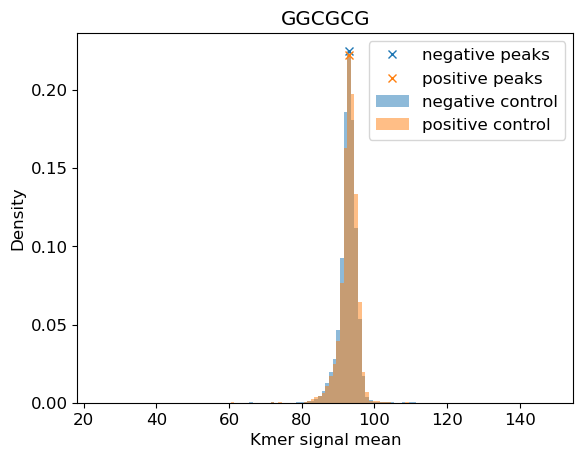

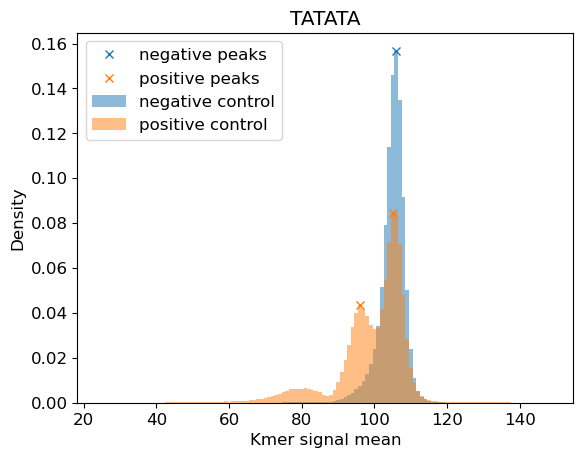

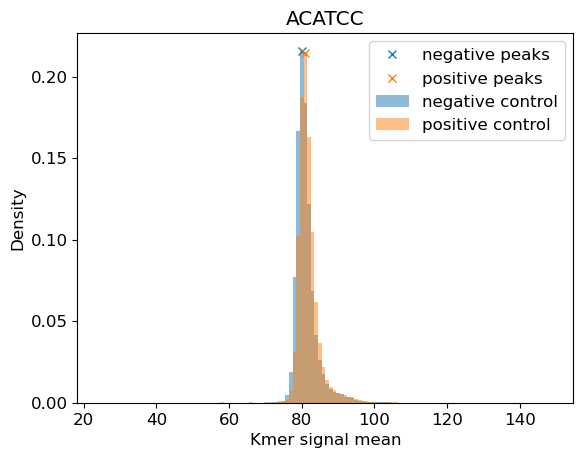

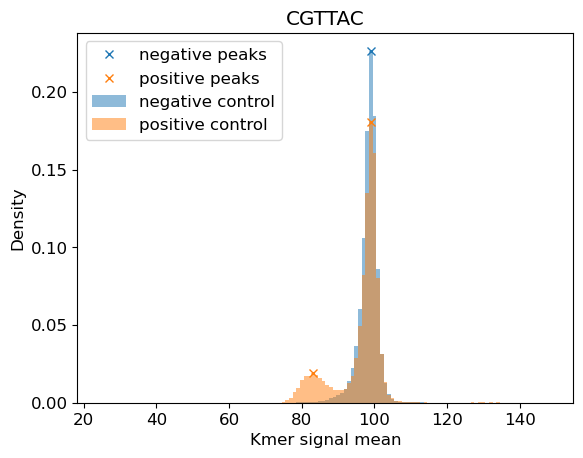

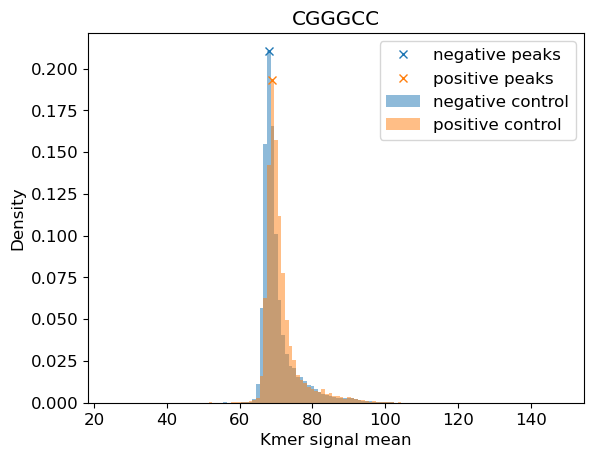

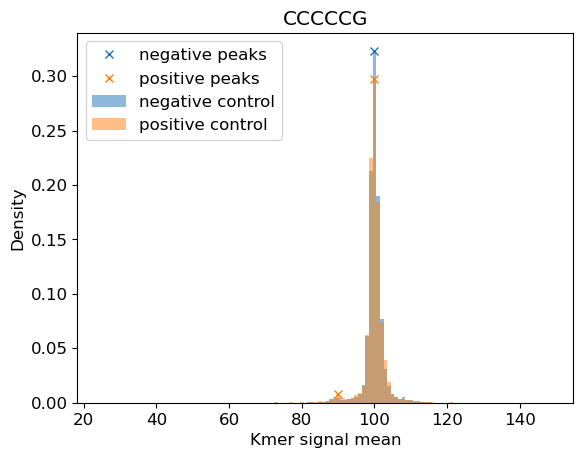

In [28]:
for kmer in ['GGCGCG', 'TATATA', 'ACATCC', 'CGTTAC', 'CGGGCC', 'CCCCCG']:
    print(kmer)
    pos, neg = kmerpeaks[kmer]
    pospeaks, _ = find_peaks(pos, prominence=0.005, distance=5)
    negpeaks, _ = find_peaks(neg, prominence=0.005, distance=5)
    print(len(pospeaks), len(negpeaks))
    plt.figure()
    plt.bar(range(25,149), neg, width=1, label="negative control", alpha=0.5)
    plt.bar(range(25, 149), pos, width=1, label="positive control", alpha=0.5)
    plt.plot([x+25 for x in negpeaks], [neg[x] for x in negpeaks], 'x', label='negative peaks')
    plt.plot([x+25 for x in pospeaks], [pos[x] for x in pospeaks], 'x', label='positive peaks')
    plt.xlabel('Kmer signal mean')
    plt.ylabel('Density')
    plt.title(kmer)
    plt.legend()
    plt.savefig("../figures/5_500_angelicin_ctrl_sig_dist_" + kmer + "_withpeaks.pdf", dpi=600)

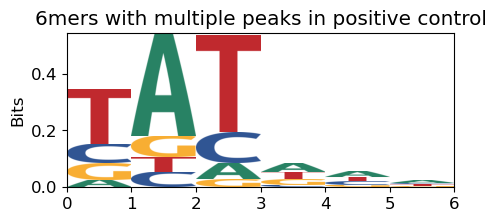

In [18]:
seqfile = '../data/uncalled_eventalign/5_500_angelicin_informative_kmers.tsv'

plotMotiffromFile(seqfile, outpath= '../figures/', seqlen=6, figsize=(5,2),
                  prefix = '5_500_angelicin_informative_kmers', title = '6mers with multiple peaks in positive control')

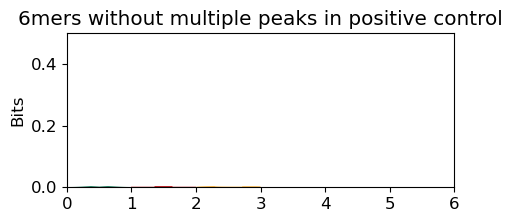

In [19]:
seqfile = '../data/uncalled_eventalign/5_500_angelicin_non_informative_kmers.tsv'

plotMotiffromFile(seqfile, outpath= '/private/groups/brookslab/gabai/projects/Add-seq/results/', seqlen=6, figsize=(5,2), y_lim=(0, 0.5),
                  prefix = '240929_angelicin_non_informative_kmers', title = '6mers without multiple peaks in positive control')

In [20]:
# percentage of informative kmers:
total = 4 ** 6
len(l)/total

0.041259765625